<h1><center>Laboratorio 6: La desperación de Mr. Lepin 🐼</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Pablo Badilla
- Auxiliar: Ignacio Meza D.
- Ayudante: Patricio Ortiz

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Matías Vergara Silva
- Nombre de alumno 2: -

Hoy no hay fotos de gatitos, solo ganas de terminar el semestre y dormir


### **Link de repositorio de GitHub:** `https://github.com/matiasvergaras/MDS7201`

### Indice 

1. [Temas a tratar](#Temas-a-tratar:)
3. [Descripcción del laboratorio](#Descripción-del-laboratorio.)
4. [Desarrollo](#Desarrollo)

# Temas a tratar

- Aplicar Pandas para obtener características de un DataFrame.
- Aplicar Pipelines.
- Aplicar Clusters sobre un conjunto de datos.

## Reglas:

- Fecha de entrega: 09/06/2021
- **Grupos de 2 personas**
- **Ausentes** deberán realizar la actividad solos. 
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias. 
- Pueden usar cualquer matrial del curso que estimen conveniente.
- Código que no se pueda ejecutar, no será revisado.

### Objetivos principales del laboratorio

- Comprender y aprovechar las ventajas que nos ofrece la librería `pandas` con respecto a trabajar en Python 'puro'.
- Crear nuevas características para entrenar un modelo de clustering.
- Comprender como aplicar pipelines de Scikit-Learn para generar procesos más limpios.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `numpy`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre arreglos (*o tensores*).

## Descripción del laboratorio.

### Importamos librerias utiles 😸

In [16]:
# Libreria Core del lab.
import numpy as np
import pandas as pd
import datetime
from IPython.display import HTML

# Libreria para plotear (En colab esta desactualizado plotly)
!pip install --upgrade plotly
import plotly.express as px
import plotly.graph_objects as go

# Librerias utiles
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
# Si usted está utilizando Colabolatory le puede ser útil este código para cargar los archivos.
try:
    from google.colab import drive
    drive.mount("/content/drive")
    path = 'Dirección donde tiene los archivos en el Drive'
except: 
    print('Ignorando conexión drive-colab')

Ignorando conexión drive-colab


# Segmentación de Clientes en Tienda de Retail 🛍️

<p align="center">
  <img width=300 src="https://s1.eestatic.com/2018/04/14/social/la_jungla_-_social_299733421_73842361_854x640.jpg">
</p>

## 1.1 Cargar Dataset

Mr. Lepin, en una nueva reunión, le cuenta a ud y su equipo que los resultados derivados del análisis exploratorio de dato presentaron una gran utilidad para la empresa y que tiene un gran entusiasmo por continuar trabajando con ustedes.
Es por esto, que Mr. Lepin les pide que cargue y visualicen algunas de las filas que componen el Dataset.
A continuación un extracto de lo parlamentado en la reunión:

    - Usted: Es un gran logro para nuestro equipo que usted haya encontrado excelente el EDA. ¿Qué tiene en mente ahora?
    - Mr. Lepin: Resulta que hace algún tiempo, mientras tomaba un mojito en una reunión de gerentes en Panamá, oí a un *chato* acerca de **LRMFP**, que es un modelo que permite personificar a los clientes a través de la farbicación de distintos atributos que describen a los clientes. Lo encontré es-tu-pendo ñatito. 
    - Usted: Ehh bueno. Investigaremos acerca de este modelo y veremos lo que podemos hacer.

Por ende, su siguiente tarea es calcular **LRMFP** sobre cada cliente y luego hacer un análisis de las características generadas. Para esto, el área de ventas les entrega un nuevo archivo llamado `online_retail_II_cleaned.pickle`, quien posee los datos del DataFrame original limpios y listos para obtener las características solicitadas por Mr. Lepin.

In [3]:
df_retail = pd.read_pickle("online_retail_II_cleaned.pickle")
df_retail = df_retail.astype(
    {
        "Invoice": "category",
        "StockCode": "category",
        "Description": "category",
        "Description": str,
        "Customer ID": "category",
        "Country": "category"
    }
)
df_retail.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## 1.2 Creación de nuevas Caracteristicas [2 Puntos] 

Como ya se les comento, Mr. Lepin esta interesado en obtener las características **LRMFP**, para esto les señala que estas características se construyen en base a las siguientes definiciones:

- **Length (L)**: Intervalo de tiempo, en días, entre la primera y la última visita del cliente. Mientras mas grande sea el valor, mas fiel es el cliente.
- **Recency (R)**: Indica la actualidad de la interacción de un cliente con la empresa, y da información sobre la tendencia a repetir la compra. Se define como: 
$$Recency(n)=\dfrac{1}{n} \sum^n_{i=1} date\_diff(t_{fecha final}, t_{m-i+1})$$

 Donde $date\_diff$ representa la diferencia en días entre la fecha de finalización del periodo de observación ($t_{fecha final}$), y la fecha de una visita del cliente cercana a $t_{fecha final}$, $t_{m-i+1}; t_{m}$ es la última visita del cliente; y n es el número de visitas recientes del cliente consideradas.

- **Monetary (M)**: El término "monetario" se refiere a la cantidad media de dinero gastada por cada visita del cliente durante el período de observación y refleja la contribución del cliente a los ingresos de la empresa.

- **Frequency (F)**: Se refiere al número total de visitas del cliente durante el periodo de observación. Cuanto mayor sea la frecuencia, mayor será la fidelidad del cliente. 

- **Periodicity (P)**: Representa si los clientes visitan las tiendas con regularidad.

$$Periodicity(n)=std(IVT_1, ..., IVT_n)$$

&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Donde $IVT$ denota el tiempo entre visitas y n representa el número de valores de tiempo entre visitas de un cliente.
 

$$IVT_i=date\_diff(t_{i+1},t)$$

En base a las definiciones señaladas, diseñe una función que permita obtener las características **LRMFP** recibiendo un DataFrame como entrada. Para esto, no estará permitido el uso de iteradores, utilice todas las herramientas que les ofrece `pandas` para realizar esto.

Una referencia que le puede ser útil es el [documento original](https://www.researchgate.net/publication/315979555_LRFMP_model_for_customer_segmentation_in_the_grocery_retail_industry_a_case_study) en donde se propone este método.

**Nota:** Para la $fechafinal$ utilice la fecha máxima del dataset más 1 día.

**Ejemplo de Resultado Esperado:**

| Customer ID | Length | Recency | Frequency | Monetary | Periodicity |
|------------:|-------:|--------:|----------:|---------:|------------:|
|   12346.0   |    294 |      67 |        46 |   -64.68 |        37.0 |
|   12347.0   |     37 |       3 |        71 |  1323.32 |         0.0 |
|   12349.0   |    327 |      43 |       107 |  2646.99 |        78.0 |
|   12352.0   |     16 |      11 |        18 |   343.80 |         0.0 |
|   12356.0   |     44 |      16 |        84 |  3562.25 |        12.0 |

**Respuesta:**

In [4]:
def custom_features(dataframe_in):
    df_aux = dataframe_in.copy() 
    final_date = df_aux['InvoiceDate'].max() + datetime.timedelta(days = 1) 
    df_aux['Mount'] = df_aux['Price'] * df_aux['Quantity']
    # agrupamos por invoice para que las caracteristicas promediadas (monetary, recency)
    # dividan por el numero de boletas (visitas) y no por el numero de pares (boleta, objeto)
    # *decisión verificada con el equipo docente en Discord.
    df_aux = df_aux.groupby('Invoice').agg(
        {'Customer ID': 'first', 
         'InvoiceDate': 'first',
         'Mount': 'sum'}).reset_index()

    # variables auxiliares
    df_aux['recency'] = (final_date - df_aux['InvoiceDate']).dt.days
    df_aux['prevDate'] = df_aux.groupby('Customer ID')['InvoiceDate'].shift(periods=1)
    df_aux['diffDate'] = (df_aux['InvoiceDate'] - df_aux['prevDate']).dt.days 
    
    # calculamos ahora las características por cliente
    df_customer = df_aux.groupby('Customer ID')
    lrmfp = pd.DataFrame()
    lrmfp['Length'] = (df_customer['InvoiceDate'].max() - df_customer['InvoiceDate'].min()).dt.days
    lrmfp['Recency'] = df_customer['recency'].mean()
    lrmfp['Frequency'] = df_customer.size()
    lrmfp['Monetary'] = df_customer['Mount'].mean()
    lrmfp['Periodicity'] = df_customer['diffDate'].std()
    return lrmfp.dropna(0) # las metricas pierden sentido para quienes tienen una sola compra

In [5]:
df_custom = custom_features(df_retail)
display(df_custom)

C:\Users\m_jvs\AppData\Local\Temp\ipykernel_14760\4073437618.py:25: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  return lrmfp.dropna(0) # las metricas pierden sentido para quienes tienen una sola compra


,Length,Recency,Frequency,Monetary,Periodicity
Customer ID,,,,,
12346.0,196,325.181818,11,33.896364,36.659999
12349.0,181,158.000000,3,890.380000,101.823376
12356.0,44,35.000000,3,1186.766667,13.435029
12358.0,356,188.000000,3,906.336667,4.949747
12359.0,308,250.000000,6,427.226667,45.850845
...,...,...,...,...,...
18272.0,97,232.333333,3,435.800000,0.707107
18276.0,336,169.800000,5,264.132000,37.349699
18277.0,97,86.250000,4,267.417500,40.673497


**Resúesta de Pauta:**

## 1.3 Pipelines 👷

Finalmente *Don Mora* le pregunta si seria posible realizar un pipeline para realizar una segmentación de los clientes con los nuevos datos generados, a lo que usted responde que **sí** y propone la utilización de k-means para la segmentación.

A continuación siga los pasos requeridos para obtener la segmentación de clientes.

### 1.3.1 Estandarizar Caracteristicas [0.5 puntos]

Construya una clase llamada ``MinMax()`` utilizando ``BaseEstimator`` y ``TransformerMixin`` para realizar una transformación de cada una de las columnas de un DataFrame utilizando ``ColumnTransformer()`` más tarde (tome como referencia el siguiente [enlace](https://sklearn-template.readthedocs.io/en/latest/user_guide.html#transformer)).


 Para esto considere que Min-Max escaler queda dada por la ecuación:

$$MinMax = \dfrac{x-min(x)}{max(x) - min(x)}$$

Con esto buscamos que los valores que componen a las columnas se muevan en el rango de valores $[0, 1]$.

**Respuesta:**

In [6]:
class MinMax(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
        return X

### 1.3.2 `T-SNA` Pipeline [1.0 puntos]

Para comenzar introduciéndose en el uso de pipeline, decide probar realizando un pipeline enfocado en la reducción de dimensionalidad y así hacer no decepcionar a Mr. Lepin con la clusterización del modelo. 

Configure un pipeline utilizando el algoritmo `T-SNE` sobre los datos **LRMFP**, donde, para la realización del pipeline considera los siguientes pasos:

1. Como primer paso obtenga las características **LRMFP** desde el DataFrame ``df_retail_II_cleaned.pickle`` utilizando la función ``custom_features`` creada anteriormente, junto a ``FunctionTransformer()``. Considere esto como el primer paso de su pipeline.
2. En segundo lugar usando ``ColumnTransformer()`` aplique el MinxMax scaler creado por usted sobre todas las columnas generadas en el paso anterior. 
3. Finalmente, aplique un último paso donde obtiene las 2 componentes más relevantes utilizando el algoritmo T-sne de sckit-learn.

Tras aplicar las transformaciones sobre el dataset **LRMFP**, gráfique las componentes obtenidas en la reducción de dimensionalidad.

**Respuesta:**

In [33]:
LRMFP_Pip = Pipeline([
    ('Features', FunctionTransformer(custom_features)), 
    ('MinMax', ColumnTransformer(transformers = 
                                 [('MinMax', MinMax(), 
                                   ['Length', 'Recency', 'Frequency', 'Monetary', 'Periodicity']) 
                                 ])),
    ('T-SNE', TSNE(n_components=2))
])
    

LRMFP = LRMFP_Pip.fit_transform(df_retail)
df_LRMFP = pd.DataFrame(LRMFP, columns=['x', 'y'])
display(df_LRMFP)

,x,y
0,26.778103,-24.926804
1,3.494544,-21.290749
2,-0.612143,-75.035782
3,-4.601062,63.806656
4,9.682432,16.254330
...,...,...
2078,19.892914,-34.776760
2079,11.833226,49.130852
2080,-8.314766,-50.468079
2081,5.408779,8.438771


<AxesSubplot:title={'center':'2 Componentes Principales mediante t-SNE, a partir de LRMFP sobre clientes'}, xlabel='x', ylabel='y'>

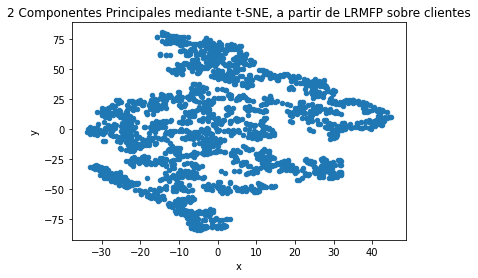

In [34]:
df_LRMFP.plot.scatter(x='x', y='y', title='2 Componentes Principales mediante t-SNE, a partir de LRMFP sobre clientes')

### 1.3.3 Clustering

#### 1.3.3.1 Método del Codo [1 puntos]

Utilizando la clase creada para escalamiento, aplique el método del codo para visualizar cual es el número de clusters que mejor se ajustan a los datos. Realice esto utilizando el algoritmo K-means dentro de un pipeline para un $k \in [1,20]$, donde k representa el número de clusters del k-means. Para la realización de esta sección y la próxima (1.3.3.2), considere los mismos pasos utilizados para el t-sne, pero permutando el algoritmo de reducción de dimensionalidad por k-means.

A través del grafico obtenido, comente y justifique que valor de k escogería para realizar el k-means.

**Respuesta:**

In [30]:
# para evitar llamar 20 veces a custom_features (por ejecutar 20 veces el pipeline),
# usaremos una funcion que internamente itere sobre KMeans entre 1 y 20 clusters
# y la posicionaremos al final del pipeline (que entregara ahora un arreglo de inercias)
def test_kmeans(dataframe_in, n_clusters=20):
    inertias = []
    for i in range(1, n_clusters + 1):
        inertias.append(KMeans(n_clusters=i, random_state=0).fit(dataframe_in).inertia_)

    inertias = pd.DataFrame(zip(range(1, n_clusters+1),inertias), columns=["n_clusters", "inertia"])
    return inertias

LRMFP_Pip = Pipeline([
                ('Features', FunctionTransformer(custom_features)), 
                ('MinMax', ColumnTransformer(transformers = 
                             [('MinMax', MinMax(), 
                               ['Length', 'Recency', 'Frequency', 'Monetary', 'Periodicity']) 
                             ])),
                ('KMeans-multiple', FunctionTransformer(test_kmeans))])
inertias = LRMFP_Pip.fit_transform(df_retail)


D:\Programas\Anaconda3\envs\MDS7201\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.



In [31]:
px.line(inertias, x="n_clusters", y="inertia", title="Método del Codo con K-Means")

Se elige trabajar con $k=4$ pues a partir de dicho valor la inercia comienza a decaer en valores menos significativos (siendo asi el punto más cercano al (0,0) en el codo).

#### 1.3.3.2 Segmentación de Clientes con K-Means 🎁 [1 punto]

En base a la elección de k realizada en la sección anterior, utilice este valor escogido y entrene un modelo de K-means utilizando el mismo pipeline de scikit-learn utilizado anteriormente.

Una vez ajustado los datos, genere una tabla con los promedios (o medianas) para cada uno de los atributos, agrupando estos por el clúster que pertenecen. ¿Es posible observar agrupaciones coherentes?, ¿Qué tipo de clientes posee el retail?, Justifique su respuesta y no decepcione a Mr. Lepin.


**Respuesta:**

In [ ]:
# Como en la sección anterior usamos una pipeline algo distinta para optimizar
# la comparación de clusters, ahora necesitaremos usar una nueva (mas simple y similar a la de t-SNE)
KMeansPip = Pipeline([
    ('Features', FunctionTransformer(custom_features)), 
    ('MinMax', ColumnTransformer(transformers = 
                                 [('MinMax', MinMax(), 
                                  ['Length', 'Recency', 'Frequency', 'Monetary', 'Periodicity']) 
                                 ])),
    ('KMeans', KMeans(n_clusters = 4))])
KMeansPip.fit_transform(df_retail)

In [ ]:
df_final = custom_features(df_retail)
df_final['Cluster'] = KMeansPip.named_steps['KMeans'].labels_
df_final = df_final.groupby('Cluster').mean()
display(df_final)

El resultado de la segmentación mediante 4 clusters nos parece razonable, en cuanto la interpretación de los promedios de variables para cada cluster da lugar a cuatro grandes grupos de clientes:
- En primer lugar, en el *cluster 0* nos encontramos con los clientes más fieles, aquellos que visitan la tienda de manera frecuente y prácticamente durante todo el periodo de observación, siendo además los que más dinero dejan. Mr. Lepin debería poner gran parte de sus esfuerzos en mantener los clientes de este segmento, pues son los más valiosos.
- Luego tenemos el *cluster 1*, con aquellos clientes con la menor presencia en cuanto a intervalo de tiempos (Length) se refiere y que coinciden además con ser aquellos de menor interacción reciente (Recency). Esto nos podría llevar a pensar que se trata de clientes sumamente eventuales y cuya importancia es discutible, sin embargo, al estudiar su promedio para Monetary nos encontramos que se trata del segundo más alto, y relativamente cercano al máximo. Lo anterior nos lleva a proponer que este grupo podría ser tan fiel como el del *cluster 0*, pero que llevan una estrategia de compras distintas: en lugar de acudir frecuentemente al supermercado por compras pequeñas, asisten unas pocas veces por compras muy grandes. Esta teoría se fortalece además por el hecho de presentar una baja Periodicity, lo cual, si nos fijamos en su fórmula, representa que los clientes son más 'ordenados' en sus visitas (visitan cada intervalos de tiempos similares). Don Lepin-Mora debería cuidar también este segmento, en especial porque perder una visita de ellos cuesta mucho más que una visita de cualquier otro segmento.
- Posteriormente tenemos el *cluster 2* de los clientes nuevos: un Length relativamente bajo pero una recencia muy alta, y que ha dejado poco al negocio. A diferencia de los grupos anteriores, para este segmento la estrategia conveniente sería invertir en fidelización en lugar de estrategias para mantenerlos felices, pues es esperable que muchos de ellos sean compradores eventuales. 
- Finalmente se tiene el *cluster 3* de los clientes ''fieles pero desordenados''. Visitan la tienda en un rango amplio de fechas y sus últimas interacciones son relativamente recientes, pero no lo hacen de manera tan seguida como el *cluster 0* ni con montos tan elevados como los *clusters 0 y 1*. Su periodicidad, por otra parte, refleja una alta desviación estándar en los intervalos entre visitas: a veces vienen seguido para después desaparecer, o viceversa. Son clientes complicados, para los cuales podría teorizarse que dividen sus compras entre más de una tienda. Se recomienda estudiar las compras de este grupo en mayor profundidad para validar dicha hipótesis.


**Respuesta Esperada:**

|         | Length  | Recency   | Frequency | Monetary | Periodicity |       |
|---------|---------|-----------|----------|-------------|-------|-------|
| Cluster |         |           |          |             |       |       |
|    0    |   258.8 |      45.2 |     76.1 |      1107.7 | 107.6 |   449 |
|    1    |    76.1 |     217.6 |     45.5 |       791.7 |  14.1 |   466 |
|    2    |   368.5 |       4.8 |   2715.0 |    226621.6 |   4.2 |     4 |
|    3    |    85.3 |      45.7 |     65.8 |      1047.0 |  10.5 |   987 |
|    4    |   347.2 |      15.9 |   1658.0 |     35829.3 |   8.0 |    25 |
|    5    |   298.0 |      29.8 |    183.8 |      3639.9 |  32.0 |  1188 |

#### 1.3.3.3 Plot de K-Means 📈 [0.5 puntos]



Por último, Mr. Lepin, impaciente de no entender lo que usted intenta explicarle, le solicita que por favor muestre algún resultado "visual" de los grupos encontrados.

Para esto, grafique nuevamente las características encontradas usando `T-SNE` (no calcule de nuevo, simplemente utilice las proyecciones encontradas) y agregue las labels calculadas con kmeans como el argumento `color`.   

Comente: ¿Se separan bien los distintos clusters en la visualización?


**Respuesta:**

In [ ]:
df_LRMFP["Cluster"] = df_LRMFP["Cluster"].astype(str) # para escala discreta
fig = px.scatter(df_LRMFP, x=0, y=1, color= 'Cluster', title='Segmentación de clientes en base a LRMFP mediante K-Means')
fig.show()

La visualización permite notar que los clusters no están tan compactos ni tan separados como se quisiera - lo cual en parte es esperable, dado lo complejo del problema que representan -. Si se observa, sin embargo, un traslape casi inexistente entre clusters y un cluster 3 bastante bien definido en comparación a sus pares, así como la cercanía del cluster 2 con todos los demás (con los que compran hace poco). Esto es razonable, en cuanto los clientes nuevos potencialmente saltarán a alguno de los otros clusters al pasar más tiempo.

Cabe notar que los clientes que solo acudieron una vez no se representan por ningún cluster, pues fueron eliminados del estudio en la generación de características (pues muchas perdían sentido al existir una única entrada).

<br>
<center>
<img src="https://i.kym-cdn.com/photos/images/original/001/194/195/b18.png" width=100 height=50 />
</center>
<br>

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>